
# Step 4 — Feature Engineering (Telco Churn)

**What this notebook does**
1. Load the base dataset `telco_churn_dataset.csv`
2. Create richer features (tenure buckets, average spend, service counts, simple interactions)
3. Quick visual checks (matplotlib only)
4. Save engineered dataset as `telco_churn_features.csv`
5. (Sanity) Train a quick RandomForest on engineered features to verify signal


In [1]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

# Load dataset
csv_path = Path("telco_churn_dataset.csv")
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
df.head()


Shape: (500, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,nTGzL-10508,Female,0,Yes,No,10,Yes,No,Fiber optic,No,...,Yes,No,No,Yes,Month-to-month,No,Bank transfer (automatic),27.78,324.78,No
1,IKGEp-03908,Male,0,No,No,26,No,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,89.12,2321.10,No
2,iNJcX-57530,Female,0,No,Yes,8,No,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,22.87,209.92,Yes
3,vGjSn-43687,Female,0,No,Yes,47,No,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),93.73,4422.24,Yes
4,IVBce-67057,Male,0,Yes,No,55,Yes,Yes,DSL,No,...,Yes,No,No,No,Two year,Yes,Electronic check,102.31,5633.01,Yes


In [2]:

# Basic target checks
print("Churn counts:\n", df['Churn'].value_counts())
print("Churn %:\n", (df['Churn'].value_counts(normalize=True) * 100).round(2))


Churn counts:
 Churn
No     256
Yes    244
Name: count, dtype: int64
Churn %:
 Churn
No     51.2
Yes    48.8
Name: proportion, dtype: float64


## Create engineered features

In [3]:

# 1) Tenure buckets (categorical)
def tenure_bucket(t):
    if t < 12:
        return "0-12"
    elif t < 24:
        return "12-24"
    elif t < 48:
        return "24-48"
    else:
        return "48+"

if 'tenure' in df.columns:
    df['TenureBucket'] = df['tenure'].apply(tenure_bucket)
else:
    raise ValueError("Expected column 'tenure' not found.")
    
# 2) AvgMonthlySpend (numeric) — safe divide
if {'TotalCharges','tenure','MonthlyCharges'}.issubset(df.columns):
    df['AvgMonthlySpend'] = df.apply(
        lambda r: r['TotalCharges']/r['tenure'] if r['tenure']>0 else r['MonthlyCharges'],
        axis=1
    )
else:
    raise ValueError("Expected columns 'TotalCharges','tenure','MonthlyCharges' are missing.")

# 3) ServiceCount (numeric)
service_cols = [c for c in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'] if c in df.columns]
def count_yes(row):
    cnt = 0
    for c in service_cols:
        v = str(row.get(c, "No")).strip().lower()
        if v == "yes":
            cnt += 1
    return cnt

df['ServiceCount'] = df.apply(count_yes, axis=1)

# 4) Interaction: ChargesPerService (numeric)
df['ChargesPerService'] = df['MonthlyCharges'] / (df['ServiceCount'] + 1)

# 5) Binary normalizations (map Yes/No to 1/0 where appropriate)
yn_cols = [c for c in df.columns if df[c].dtype == object and set(df[c].dropna().unique()).issubset({'Yes','No'})]
for col in yn_cols:
    df[col] = df[col].map({'Yes':1,'No':0}).astype('Int64')

print("Engineered columns added: TenureBucket, AvgMonthlySpend, ServiceCount, ChargesPerService")
df.head()


Engineered columns added: TenureBucket, AvgMonthlySpend, ServiceCount, ChargesPerService


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureBucket,AvgMonthlySpend,ServiceCount,ChargesPerService
0,nTGzL-10508,Female,0,1,0,10,1,0,Fiber optic,No,...,Month-to-month,0,Bank transfer (automatic),27.78,324.78,0,0-12,32.478000,2,9.260000
1,IKGEp-03908,Male,0,0,0,26,0,0,No,No internet service,...,Two year,0,Mailed check,89.12,2321.10,0,24-48,89.273077,0,89.120000
2,iNJcX-57530,Female,0,0,1,8,0,0,No,No internet service,...,Two year,0,Mailed check,22.87,209.92,1,0-12,26.240000,0,22.870000
3,vGjSn-43687,Female,0,0,1,47,0,0,No,No internet service,...,Two year,0,Bank transfer (automatic),93.73,4422.24,1,24-48,94.090213,0,93.730000
4,IVBce-67057,Male,0,1,0,55,1,1,DSL,No,...,Two year,1,Electronic check,102.31,5633.01,1,48+,102.418364,2,34.103333


## Quick visual checks (matplotlib only)

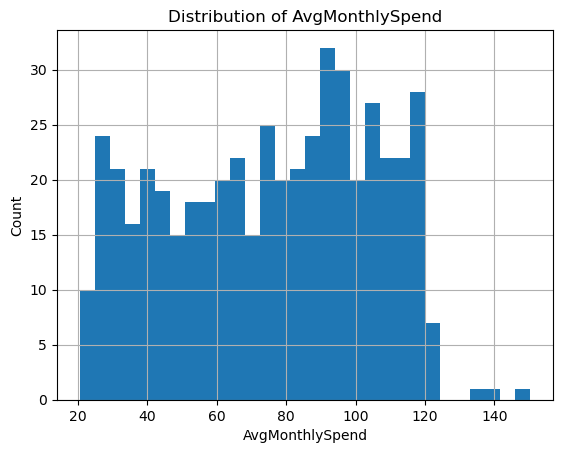

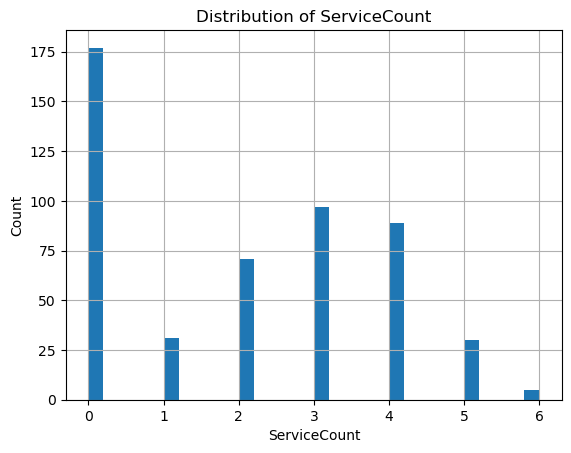

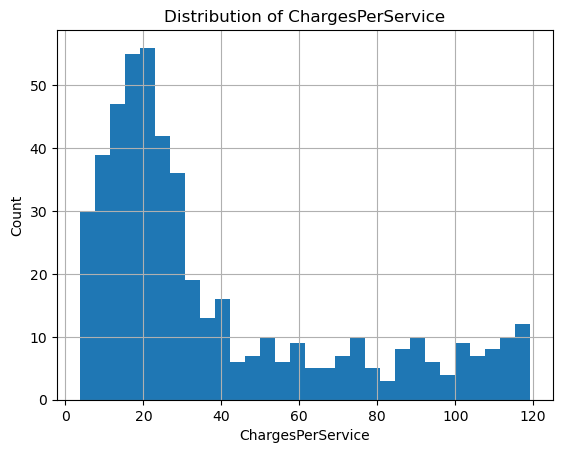

In [4]:

# Histogram examples for new numeric features
num_preview = [c for c in ['AvgMonthlySpend','ServiceCount','ChargesPerService'] if c in df.columns]
for col in num_preview:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


## Save engineered dataset

In [5]:

out_csv = Path("telco_churn_features.csv")
df.to_csv(out_csv, index=False)
out_csv.resolve()


WindowsPath('C:/Users/hussa/Downloads/telco_churn_features.csv')

## (Sanity) Quick model check on engineered features

RandomForest on engineered features
              precision    recall  f1-score   support

         0.0      0.540     0.529     0.535        51
         1.0      0.520     0.531     0.525        49

    accuracy                          0.530       100
   macro avg      0.530     0.530     0.530       100
weighted avg      0.530     0.530     0.530       100

ROC-AUC: 0.548


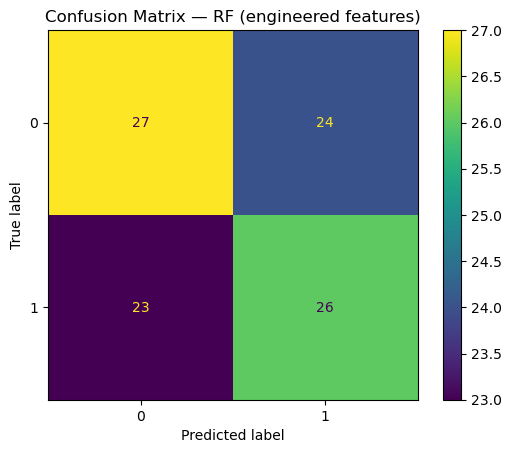

In [6]:

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

# Prepare y and X
y = (df['Churn'] == 'Yes').astype(int) if df['Churn'].dtype == object else df['Churn']
X = df.drop(columns=[c for c in ['Churn','customerID'] if c in df.columns])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

rf = Pipeline(steps=[('prep', preprocess),
                    ('model', RandomForestClassifier(n_estimators=400, random_state=42))])

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

print("RandomForest on engineered features")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix — RF (engineered features)")
plt.show()
